# Inteligêncial articial (2020/01)
### Trabalho em Grupo do Grau A

*Graph coloring problem (GCP)*

Integrantes:
*   Anderson
*   Felipe Silva
*   Gabriel Castro
*   Lucas Oliveira

Prof. Gabriel de Oliveira Ramos

---

# Definições do problema

O problema de coloração de grafos é definido por um conjuto de n nós.  O grafo resultante representa um mapa, onde os nós representam porções territoriais de países e as arestas representam a adjacência entre os territórios (territórios conectados são considerados vizinhos).

O objetivo deste *notebook* é criar um algoritmo que definirá uma cor para cada nó de modo que nós adjacentes (vizinhança) não possuam a mesma cor. E ao mesmo tempo, deve-se minimizar a quantidade de cores utilizadas.

**As intâncias disponíveis são:**
*   anna (coloração completa com 11 cores)
*   games120 (coloração completa com 9 cores)
*   myciel6 (coloração completa com 7 cores)

**Input de dados**

Os territórios são definidos através de um arquivo carregado, sendo ele formatado da seguinte maneira:
*   1º: tamanho do problema definido na primeira linha, onde:
    *  segundo item da linha define a quantidade de nós
    *  terceiro item da linha define a quantidade de arestas
*   2º: demais linhas representam as arestas do grafo, para isso:
    *  representamos a conexão entre um país e outro através de uma tupla

Para exemplo, demonstramos abaixo o formato do arquivo, com uma breve explicação de cada linha:

```
    p 10,19      --> 10: nós | 19: arestas
    0,9          --> brasil - venezuela
    0,7          --> brasil - colômbia
    0,6          --> brasil - peru
    ...
```

> Obs.: esse é um exemplo apenas para iniciar o desenvolvimento, contudo os txt originais possuem mais dados
---


# Inicializações necessárias

In [0]:
import io
import pandas as pd
import random
import bisect
from google.colab import files
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [34]:
uploaded_countries = files.upload()

Saving connected_countries.txt to connected_countries.txt


Para iniciar, vamos usar a função `read_csv` da biblioteca pandas. Ela permite fazermos a leitura do arquivo carregado anteriormente, acessando assim os elementos necessários. 

Note que o arquivo está sem cabeçalho, porém seria possível a utilização de um dentro do arquivo. Mas por escolha, foi definido ter somente os dados.

E já que não inserimos o nome das colunas no arquivo, o próprio DataFrame define como padrão o nome delas, enumerando de 0 até n quantidade de colunas - 1. Isso é uma coisa ruim para acessos posteriores, portanto, usamos a função `rename` para alterá-las.

In [0]:
# comment if local run
df = pd.read_csv(io.BytesIO(uploaded_countries['connected_countries.txt']), header=None, delim_whitespace=True)
df.rename(columns={
    0: 'x',
    1: 'y',
    2: 'z'
}, inplace=True)

# uncomment if local run
# df = pd.read_csv('D:\\Repositórios\\GitHub\\Personal\\Unisinos-IA-Exercicios\\Trabalho_GA\\connected_countries.txt', header=None, delim_whitespace=True)
# df.rename(columns={
#     0: 'x_country',
#     1: 'y_country'
# }, inplace=True)

In [36]:
df.head()

,x,y,z
0,p,15,27.0
1,0,9,NaN
2,0,7,NaN
3,0,6,NaN
4,0,4,NaN


Com os dados já armazenados no DataFrame, passamos a separá-los em duas estruturas de dados:
*   Tupla para a definição do problema (quantidade de nós e arestas);
*   Dicionário com listas combinando dados conectados através das arestas.

Como exemplo, segue uma exemplificação das conexões entre as arestas.

<img src="https://raw.githubusercontent.com/gabcastro/Unisinos-IA-Exercicios/master/Trabalho_GA/graph_colors_countries.jpg" alt="Exemplo de conexões" height="480">

In [0]:
problem_length = (int(df.iloc[0]['y']), int(df.iloc[0]['z']))     # tuple with len of nodes and edges

countries = {
    0: 'BR',    # Brasil
    1: 'UY',    # Uruguai
    2: 'PY',    # Paraguai
    3: 'AR',    # Argentina
    4: 'BO',    # Bolívia
    5: 'CH',    # Chile
    6: 'PE',    # Peru
    7: 'CO',    # Colômbia
    8: 'EC',    # Ecuador
    9: 'VE',    # Venezuela
    10: 'GY',   # Guiana
    11: 'SR',   # Suriname
    12: 'GF',   # Guiana Francesa
    13: 'PA',   # Panamá
    14: 'CR'    # Costa Rica
}

connected_countries = {}

for index, row in df.tail(len(df)-1).iterrows():
    str_countries = countries.get(int(row['x'])) + '-' + countries.get(row['y'])
    # connected_countries[str(random.randrange(0, 2000))] = [int(row['x']), row['y']]
    connected_countries[str_countries] = [int(row['x']), row['y']]

# set of possible colours (pink, orange, green, gray, purple, yellow, blue, red, white, brown, black)
possible_values = ['P', 'O', 'GN', 'GY', 'P', 'Y', 'B', 'R', 'W', 'BR', 'BK'] 

# Algoritmo de busca para solução do problema

Para o problema de coloração de grafos, foi escolhido usar o algoritmo genético pois permite uma busca mais variada, diferente do Hill Climbing que após achar o primeiro ótimo local encerra a solução do problema.

Os AGs começam com um conjunto de *k* estados gerados aleatoriamente, chamado **população**. Cada estado, ou **indivíduo**, é representado como uma cadeia sobre um alfabeto finito. 

A produção de uma nova geração passa por algumas etapas, onde seguem uma sequência de passos:

*   **Função de adaptação (fitness)**: Retorna valores mais altos para estados melhores. A probabilidade de um indivíduo ser escolhido para reprodução é diretamente proporcional à sua pontuação de adaptação.
*   **Seleção**: Dois pares escolhidos aleatoriamente são selecionados para reprodução, de acordo com as probabilidades da função fitness.
*   **Cruzamento (*Crossover*)**: Pares são cruzados, a escolha é realizada ao acaso em um ponto de cruzamento dentre as posições na cadeia. Os próprios descendentes são criados por cruzamento das cadeias pais no ponto de crossover.
Ainda pode acontecer de dois estados pais serem bastante diferentes, fazendo com que a operação de cruzamento produza um estado que está longe do estado de qualquer pai.
*   **Mutação**: Cada posição está sujeita à mutação aleatória com uma pequena probabilidade independente.

---


Classe para calcular a aptidão de um indivíduo como o número de pares de territórios vizinhos que possuem cores diferentes.

In [0]:
class EvaluateGC:
    """Evaluation class.

    Since that a solution needs to be evaluated with respect to the problem instance 
    in consideration, we created this class to store the problem instance and to 
    allow the evaluation to be performed without having the problem instance at hand.
    """
    
    # during initialization, store the problem instance
    def __init__(self, problem_instance):
        self.problem_instance = problem_instance
    
    # compute the value of the received solution
    def __call__(self, solution):
        return sum(solution[n1] != solution[n2] for (n1, n2) in self.problem_instance.values())

In [0]:
class GeneticAlgorithm:

    def genetic_algorithm(self, population, fn_fitness, gene_pool, fn_thres=None, ngen=1000, pmut=0.1):
        """ Population creation pipeline
            
            Keywords arguments:
                population  -- initial population
                fn_fitness  -- evaluation function (EvaluateGC)
                gene_pool   -- set of possible values for each position of the solution
                fn_thres    -- stop criterion for solution quality (default None)
                ngem        -- maximum number of generations (default 1000)
                pmut        -- mutation probability (default 0.1)
        """
    
        # for each generation
        for i in range(ngen):

            # create a new population
            new_population = []

            # repeat to create len(population) individuals
            for i in range(len(population)):
            
                # select the parents
                p1, p2 = self.select(2, population, fn_fitness)

                # recombine the parents, thus producing the child
                child = self.recombine(p1, p2)

                # mutate the child
                child = self.mutate(child, gene_pool, pmut)

                # add the child to the new population
                new_population.append(child)

            # move to the new population
            population = new_population

            # check if one of the individuals achieved a fitness of fn_thres; if so, return it
            fittest_individual = self.fitness_threshold(fn_fitness, fn_thres, population)
            if fittest_individual:
                return fittest_individual

        # return the individual with highest fitness
        return max(population, key=fn_fitness)
  

    def fitness_threshold(self, fn_fitness, fn_thres, population):
        """Get the best individual of the received population and return it if its 
        fitness is higher than the specified threshold fn_thres
        """

        if not fn_thres:
            return None

        fittest_individual = max(population, key=fn_fitness)
        if fn_fitness(fittest_individual) >= fn_thres:
            return fittest_individual

        return None

    
    def select(self, r, population, fn_fitness):
        """Implements the genetic selection operator.
        Genetic operator for selection of individuals; 
        This function implements roulette wheel selection, where individuals with 
        higher fitness are selected with higher probability.
        """

        fitnesses = map(fn_fitness, population)
        sampler = self.weighted_sampler(population, fitnesses)
        return [sampler() for i in range(r)]

    
    def weighted_sampler(self, seq, weights):
        """Return a single sample from sequence. 
        The probability of a sample being returned is proportional to its weight
        """

        totals = []
        for w in weights:
            totals.append(w + totals[-1] if totals else w)
        return lambda: seq[bisect.bisect(totals, random.uniform(0, totals[-1]))]

    
    def recombine(self, x, y):
        """Genetic operator for recombination (crossover) of individuals.

        This function implements single-point crossover, where the resulting individual
        carries a portion [0,c] from parent x and a portion [c,n] from parent y, with 
        c selected at random.
        """

        n = len(x)
        c = random.randrange(0, n)
        return x[:c] + y[c:]


    def mutate(self, x, gene_pool, pmut):
        """Genetic operator for mutation. 
        
        This function implements uniform mutation, where a single element of the 
        individual is selected at random and its value is changed by a randomly chosen 
        value (out of the possible values in gene_pool).
        """
        
        # if random >= pmut, then no mutation is performed
        if random.uniform(0, 1) >= pmut:
            return x

        n = len(x)
        g = len(gene_pool)
        c = random.randrange(0, n) # gene to be mutated
        r = random.randrange(0, g) # new value of the selected gene

        new_gene = gene_pool[r]
        return x[:c] + [new_gene] + x[c+1:]


    def init_population(self, pop_number, gene_pool, state_length):
        """Generate init population. 
        
        Will create a random population.

        Keywords arguments:
            pop_number      -- len of population
            gene_pool       -- possible values to each element
            state_length    -- number of genes for each individual
        """

        g = len(gene_pool)
        population = []
        for i in range(pop_number):
            # each individual is represented as an array with size state_length, 
            # where each position contains a value from gene_pool selected at random
            new_individual = [gene_pool[random.randrange(0, g)] for j in range(state_length)]
            population.append(new_individual)

        return population

Agora que a classe do algoritmo genético está criada, podemos configurar alguns
parâmetros necessários e executá-la para ver o primeiro resultado.

Essa parte é realizada através do conjunto de 14 países conectados, com 27 arestas.

A função `exectute_pop` recebe o número de cores para realizar a criação da população, e o número de rodadas (*n_runs*).
A ideia de ser executado mais de uma vez, é apenas para ver se algoritimo realmente consegue solucionar retornando um valor satisfatório sempre, ou se em alguns casos é retornado valores diferentes.

Dentro da função é definido três tamanhos de população através da lista `population_size`. Na sequência é executado para cada população a seleção, crossover e mutação, finalizando pela avaliação do resultado.

A função então retorna duas listas, uma contendo a média das soluções para cada população. E a outra os nomes das pops.

In [0]:
def exectute_pop(num_colors, n_runs, print_msgs=False):
    """Running pipeline to solve problem
    
    Keywords arguments:
        num_colors      - number of colors to set 
        n_runs          - number of executions
        print_msgs      - print results or not (default False)

    Return:
        avg_pop         - a list with avg to each n_popuation
        groups          - a list with the length of each population
    """

    colors = [possible_values[j] for j in range(num_colors)]

    # length of an individual (one position per territory)
    individual_length = problem_length[0]

    # population size
    population_size = [3, 20, 200]

    dict_avg_pop = {}
    
    for i in population_size:
        dict_avg_pop[str(i)] = []    
    
    # evaluation class
    fn_fitness = EvaluateGC(connected_countries)

    for i in range(n_runs):
        
        # instance of generic algorithm
        gen_alg = GeneticAlgorithm()

        # list to record solutions for each population 
        solutions = []

        for p in population_size:

            # initial population
            population = gen_alg.init_population(p, colors, individual_length)

            # run the algoritm
            solution = gen_alg.genetic_algorithm(population, fn_fitness, gene_pool=colors, fn_thres=problem_length[1])

            solutions.append(solution)

        ps = 1
        for s in solutions:
            # print the results
            val = fn_fitness(s)
            if print_msgs:
                print('- {}º population'.format(ps))
                print('- Length: {}'.format(population_size[ps-1]))
                print('- Resulting solution: %s' % s)
                print('- Value of resulting solution: %d\n' % val)
            
            lista_temp = dict_avg_pop.get(str(population_size[ps-1]))
            lista_temp.append(val)
            dict_avg_pop[str(population_size[ps-1])] = lista_temp

            ps += 1

        if print_msgs: print('------------------------------------------')

    avg_pop = []
    groups = []

    for population, list_values in dict_avg_pop.items():
        groups.append(population)
        
        avg_pop.append(
            float("{:.2f}".format(
                sum(list_values) / len(list_values)
            ))
        )

    return avg_pop, groups

A função abaixo foi definida para receber o retorno da `exectute_pop`, assim com o retorno dos dados, é possível montar um gráfico de barras para visualizar os resultados.

In [0]:
def plot_result(avg_pop, groups):
    labels = groups

    x = np.arange(len(labels)) # the label locations
    width = 0.5  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, avg_pop, width)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Avg Solution')
    ax.set_title('Avg Solution By Population Length')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    fig.tight_layout()

    plt.show()

In [0]:
avg_pop, groups = exectute_pop(7,1)

No handles with labels found to put in legend.


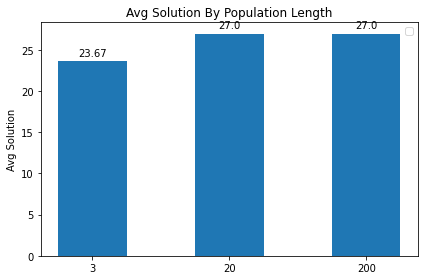

In [0]:
plot_result(avg_pop, groups)

In [0]:
avg_pop, groups = exectute_pop(9,3)

No handles with labels found to put in legend.


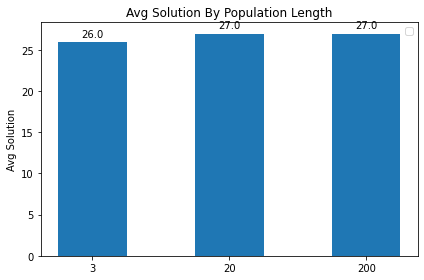

In [0]:
plot_result(avg_pop, groups)

In [0]:
avg_pop, groups = exectute_pop(11,3)

No handles with labels found to put in legend.


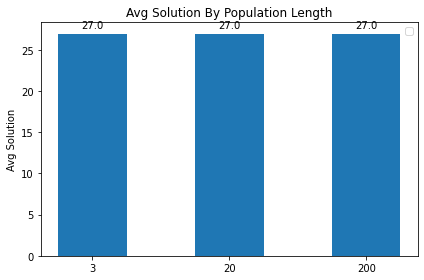

In [0]:
plot_result(avg_pop, groups)

Como é possível ver nos resultados acima, foi definido três tamanhos de população, sendo elas: 3, 20 e 200. E para a solução de 27 arestas (ótimo caso), apenas em algumas execuções para a população de tamanho 3 que foi possível identificar uma certa dificuldade em chegar no resultado ótimo. 

Muito se deve as poucas rodadas realizadas (3), sendo mais difícil de realizar a melhor seleção entre as poucas combinações.

## Considerações

O trabalho encontra-se incompleto visto que até o momento foi testado apenas com um arquivo criado para entendimento do problema, contudo no formato dos outros arquivos. Sendo necessário o carregamento dos mesmos para averiguar quais valores seriam resultantes e quais melhorias ou outros algs seriam necessários.